In [1]:
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde, norm
from astropy.table import Table, vstack

from matplotlib import transforms
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")

import time
import emcee
import corner
from multiprocessing import Pool

import mcmc_binarity

# Estimating the unresolved binary fraction in nearby open clusters

This Jupyter notebook shows how to use MCMC in conjunction with a custom mixture model to estimate the unresolved binary fraction in open clusters (given a clean membership list of main-sequence members).

The main functions used are implemented in mcmc_binarity.py.

### Read cluster-member data from the Gaia EDR3 catalogue of Tarricq+2022

The data are stored in a sub-folder of the repository, one ascii file per cluster.

In [2]:
tarricqdir = "data/Tarricq_selected_members_OCs/"
files = os.listdir(tarricqdir)
print(len(files), "OCs selected")

251 OCs selected


### Run the MCMC analysis for 1 cluster (Figure 3)

In [3]:
clusname = "Alessi_1"

In [4]:
t = Table.read(tarricqdir + clusname + "_sel_MS_members_Tarricq.txt", format="ascii")
x    = t["bp_rp"]
xerr = t["bp_rp_error"]
y    = t["phot_g_mean_mag"]
yerr = t["phot_g_mean_mag_error"]

print(clusname, ":", len(t), "stars")

# Initial guess for a MaxLikelihood fit
theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)

# Set up the MCMC sampler
nwalkers=32
nsteps=8000
burnin=3000
ndim = len(theta0)
pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

print("Running MCMC...")
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

acc_frac = np.mean(sampler.acceptance_fraction)
print("Mean acceptance fraction: {0:.2f}".format(acc_frac))

# Get the marginalised fit parameters
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                np.round(v[2]-v[1],3), 
                                                                np.round(v[1]-v[0],3)), 
                                                     zip(*np.percentile(samples, [16, 50, 84], axis=0)))
# MCMC iteration plot
plt.clf()
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 3*ndim))
poly_labels    = ["$p_0$", "$p_1$", "$p_2$", "$p_3$", "$p_4$", "$p_5$", "$p_6$", "$p_7$", "$p_8$"]
mixture_labels = ["$f_b$","$\Delta G$", "$\sigma_{SS}$", "$\sigma_{BS}$"]
labels         = poly_labels[:(ndim-4)] + mixture_labels
for ii in np.arange(ndim):
    axes[ii].plot(sampler.chain[:, :, ii].T, color="k", alpha=0.4)
    axes[ii].set_ylabel(labels[ii])
axes[ndim-1].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)

Alessi_1 : 46 stars
Maximum likelihood result: [ -21.33344202  134.68878265 -205.09025079  144.63551756  -35.45832452
   -6.23250818    3.13456784]
Running MCMC...


  2%|▉                                       | 179/8000 [00:03<02:14, 58.09it/s]

emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-4:


In [ ]:
# Corner plot
fig = corner.corner(samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 15})
plt.suptitle(clusname.replace("_", " "), fontsize=25)

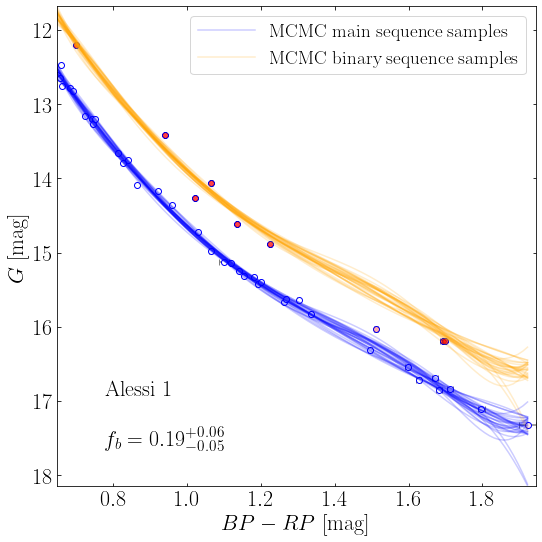

In [11]:
# CMD plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
plt.scatter(x,y, label=None, c="w")
xarr = np.linspace(np.min(x),np.max(x),100)
# Plot the maximum likelihood result.
polynom = np.poly1d(theta0[:-4][::-1])
fb_simple=[]
#plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
# Plot some MCMC samples onto the data.
for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
    bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
    plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
    binaries = (y < ms(x) - 3 * sM)
    fb_simple.append(np.sum(binaries)/len(x))
    plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
# Plot the best-parameter result.
#polynom = np.poly1d([p6_m[0],p5_m[0],p4_m[0],p3_m[0],p2_m[0],p1_m[0],p0_m[0]])
plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
plt.xlabel(r"$BP-RP$ [mag]", fontsize=22)
plt.ylabel(r"$G$ [mag]", fontsize=22)
plt.legend(loc="upper right", fontsize=19)
# Annotate name of the cluster and binary fraction
ax = plt.gca()
plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, fontsize=22)
plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("im_mcmc/im_mcmc_tarricq/cmd_fit_mcmc_"+ clusname +".png")

### Now do the polynomial test suggested by the referee

The referee suggested that, once we have a good fit to the single-star sequence, we should just use a cut in the CMD to define which stars are binaries and which not.

In this example, we take the best fitting polynomial and cut $3 \sigma_{SS}$ above the single-star sequence:

In [12]:
fb_simple=[]
for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    binaries = (y < ms(x) - 3 * sM)
    fb_simple.append(np.sum(binaries)/len(x))
fb_simple = np.percentile(np.array(fb_simple), [16, 50, 84])

Text(0.1, 0.1, '$f_b^{\\rm referee}={0.17}^{+0.00}_{-0.02}$')

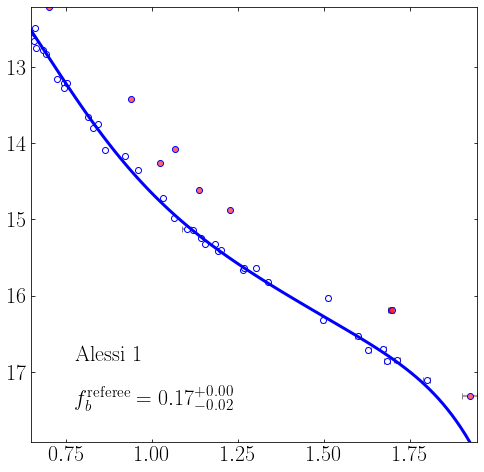

In [13]:
# CMD plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
plt.scatter(x,y, label=None, c="w")
# Overplot the 2 Gaussians
#plt.plot(kdearr, norm.pdf(kdearr, loc=0., scale=), c="k", lw=3, alpha=1)
plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.6)
plt.plot(xarr, ms(xarr), color="b", lw=3)
ax = plt.gca()
ax.invert_yaxis()
plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, fontsize=22)
plt.text(0.1, 0.1, r"$f_b^{{\rm referee}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)


### Histogram of $\Delta G_i$

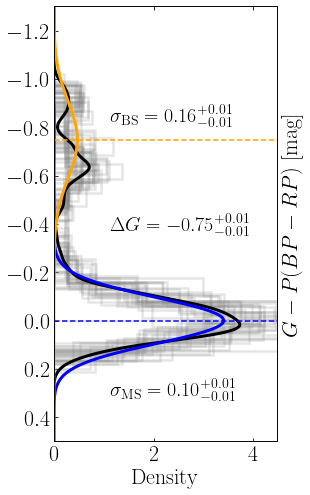

In [14]:
plt.figure(figsize=(4,8))
ax = plt.subplot(111)
# first of all, the base transformation of the data points is needed
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)

edges = [-1.3,.5]

kdearr = np.linspace(edges[0], edges[1],1000)
kderes = np.zeros(1000)

for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    # Compute Delta G_i
    DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
    vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                   label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                   color="grey", transform= rot + base)
    kde = gaussian_kde(y - ms(x), bw_method=.1)
    kderes = kderes + kde.evaluate(kdearr)
plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)

# Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)

ax.axhline(0.,      c="b", ls="dashed")
ax.axhline(DG_m[0], c="orange", ls="dashed")

# Beautify the plot
ax2 = ax.twinx() 
ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
ax.set_xlabel(r"Density") 
ax2.set_xlim(0, 1.2*np.max(kderes/30)) 
ax2.set_yticks([]) 
ax.set_ylim(edges[1], edges[0]) 


plt.text(0.25, 0.12, r"$\sigma_{{\rm SS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sM_m[0],sM_m[1],sM_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.text(0.25, 0.5, r"$\Delta G={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(DG_m[0],DG_m[1],DG_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sB_m[0],sB_m[1],sB_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.savefig("./im_mcmc/im_mcmc_tarricq/cmd_fit_residuals_" + clusname + ".png")

### Reproduce Fig. 4 (using the precomputed results)

These are the clusters that we want to plot:

In [15]:
fig4_list = ["Blanco_1", "UPK_587", "Stock_1", "UBC_582", "Gulliver_6", "IC_1396"]

Let's define some convenient plotting routines:

In [18]:
def cmd_plot(clusname, x, y, xerr, yerr, samples, results):
    # CMD plot
    plt.figure(figsize=(8,8))
    plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
    plt.scatter(x,y, label=None, c="w", edgecolors="black")
    xarr = np.linspace(np.min(x),np.max(x),100)
    fb_simple=[]
    # Plot some MCMC samples onto the data.
    for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
        ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
        plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
        bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
        plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
        binaries = (y < ms(x) - 3 * sM)
        fb_simple.append(np.sum(binaries)/len(x))
        plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
    plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
    plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
    plt.xlabel(r"$BP-RP$ [mag]", fontsize=22)
    plt.ylabel(r"$G$ [mag]", fontsize=22)
    plt.legend(loc="upper right", fontsize=19)
    # Annotate name of the cluster and binary fraction
    ax = plt.gca()
    plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
             verticalalignment='center', transform=ax.transAxes, fontsize=22)
    plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(results["fb_50"][0],results["fb_sigu"][0],results["fb_sigl"][0]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
    ax.invert_yaxis()
    # If fit quality is bad, mark background 
    if abs(results["DG_50"][0] + 0.75) > 0.1 or results["sB_50"][0] > 0.25 or results["sM_50"][0] > 0.2:
        ax.set_facecolor("mistyrose")
    plt.tight_layout()
    plt.savefig("im_mcmc/im_mcmc_tarricq/cmd_fit_mcmc_"+ clusname +".png")
    
def cmd_residuals_plot(clusname, samples, results):
    plt.figure(figsize=(4,8))
    ax = plt.subplot(111)
    # first of all, the base transformation of the data points is needed
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg(-90)

    edges = [-1.3,.5]

    kdearr = np.linspace(edges[0], edges[1],1000)
    kderes = np.zeros(1000)

    for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
        ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
        # Compute Delta G_i
        DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
        vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                       label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                       color="grey", transform= rot + base)
        kde = gaussian_kde(y - ms(x), bw_method=.1)
        kderes = kderes + kde.evaluate(kdearr)
    plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)

    # Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
    plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
    plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)

    ax.axhline(0.,      c="b", ls="dashed")
    ax.axhline(DG_m[0], c="orange", ls="dashed")

    # Beautify the plot
    ax2 = ax.twinx() 
    ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
    ax.set_xlabel(r"Density") 
    ax2.set_xlim(0, np.max([1.2*np.max(kderes/30), 5.])) 
    ax2.set_yticks([]) 
    ax.set_ylim(edges[1], edges[0]) 

    if abs(results["DG_50"][0] + 0.75) > 0.1 or results["sB_50"][0] > 0.25 or results["sM_50"][0] > 0.2:
        ax.set_facecolor("mistyrose")

    plt.text(0.25, 0.12, r"$\sigma_{{\rm SS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(results["sM_50"][0],results["sM_sigu"][0],results["sM_sigl"][0]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
    plt.text(0.25, 0.5, r"$\Delta G={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(results["DG_50"][0],results["DG_sigu"][0],results["DG_sigl"][0]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
    plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(results["sB_50"][0],results["sB_sigu"][0],results["sB_sigl"][0]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
    plt.savefig("./im_mcmc/im_mcmc_tarricq/cmd_fit_residuals_" + clusname + ".png")

And finally, create a loop that does the magic for us:

Blanco_1
UPK_587
Stock_1
UBC_582
Gulliver_6
IC_1396


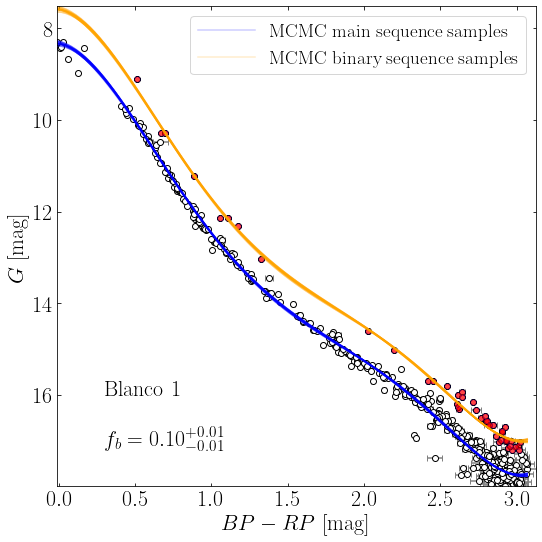

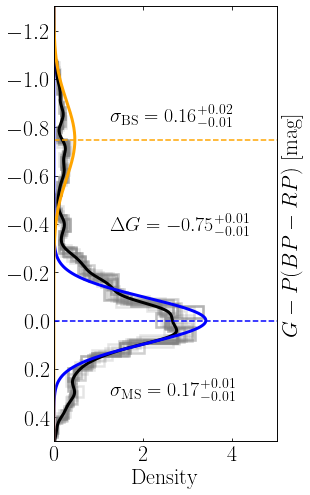

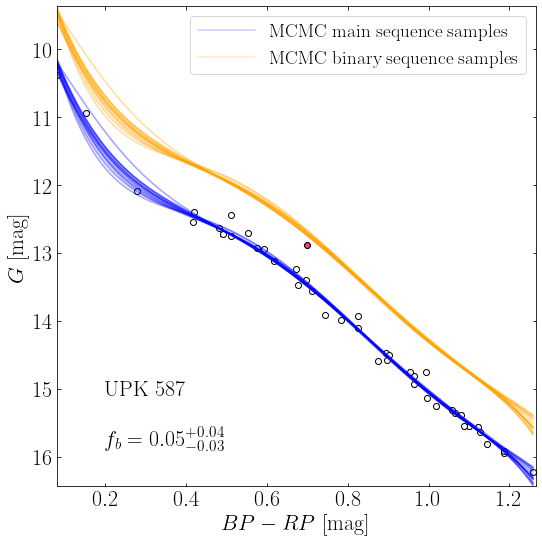

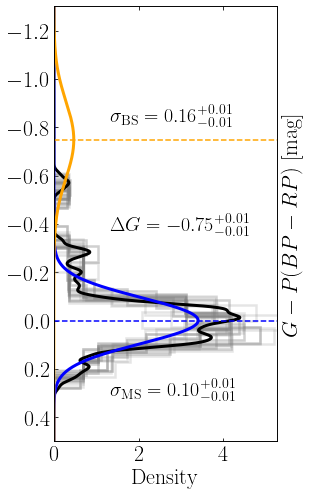

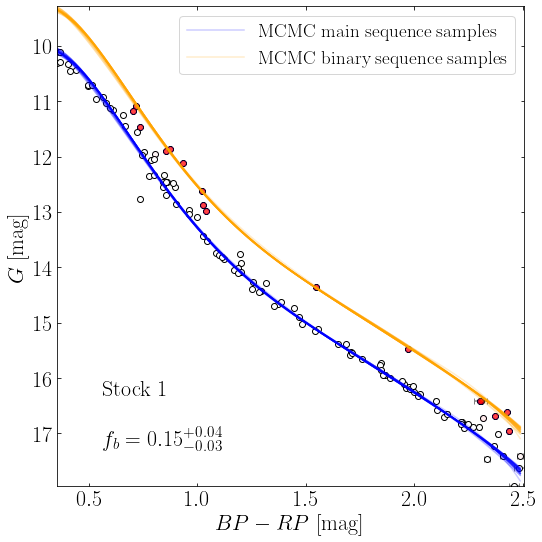

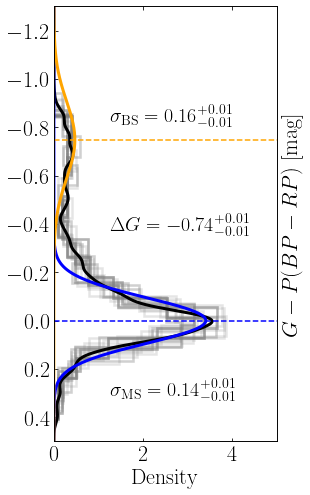

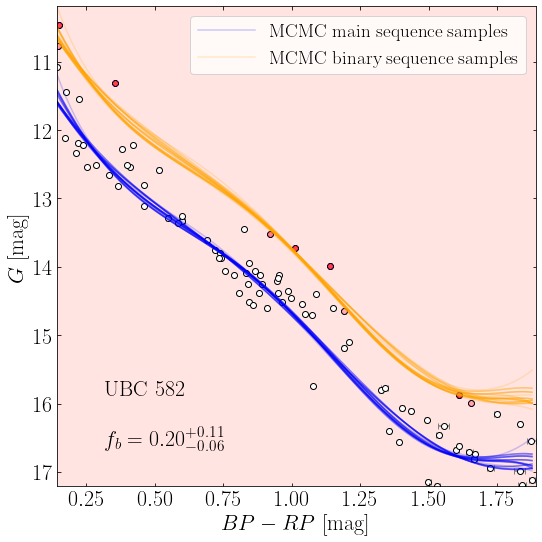

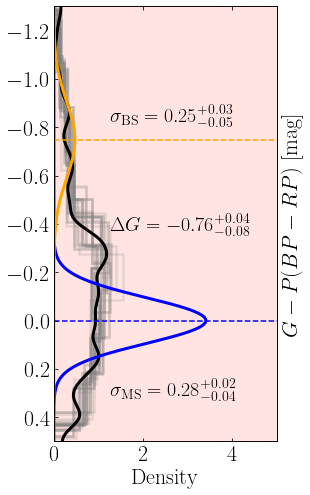

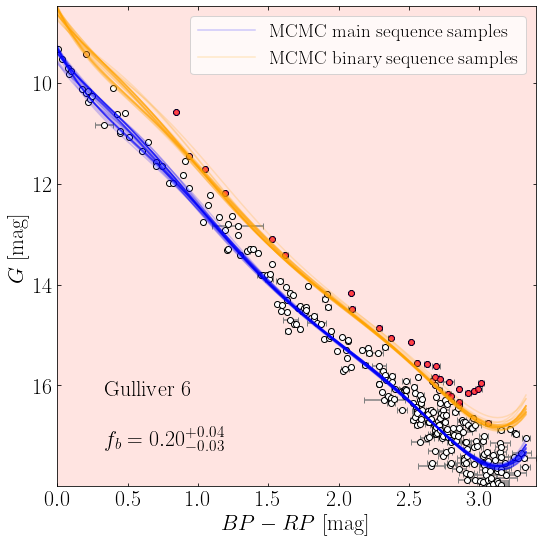

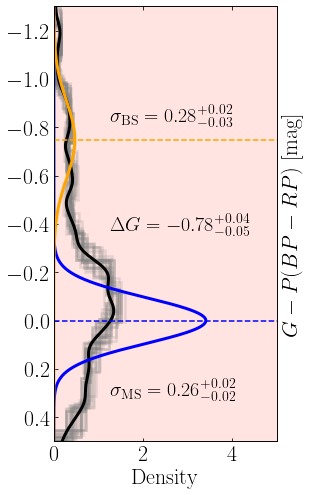

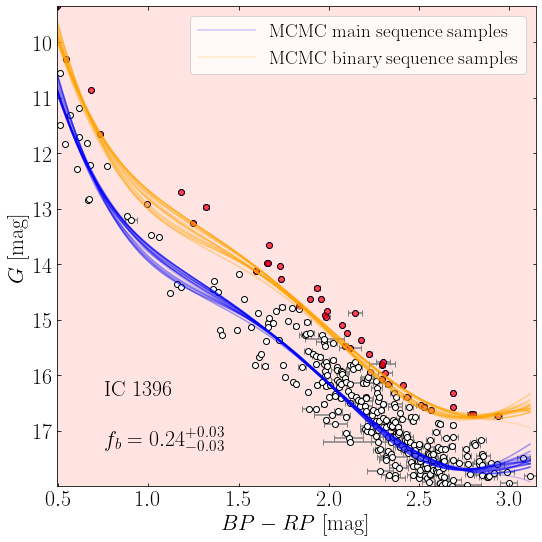

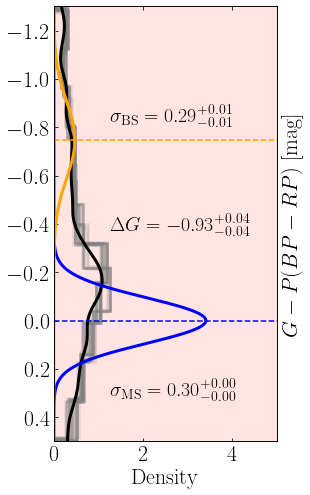

In [19]:
tarricqres = Table.read("data/mcmc_results_tarricq_summary.fits")
cantatres  = Table.read("data/mcmc_results_cantat_summary.fits")
tarricqdir = "data/Tarricq_selected_members_OCs/"
cantatdir  = "data/Cantat_selected_members_OCs_younger50Myr/"

for clusname in fig4_list:
    print(clusname)
    # Load data (main-sequence member tables and overall MCMC results)
    if clusname + "_sel_MS_members_Tarricq.txt" in os.listdir(tarricqdir):
        t = Table.read(tarricqdir + clusname + "_sel_MS_members_Tarricq.txt", format="ascii")
        x    = t["bp_rp"]
        xerr = t["bp_rp_error"]
        y    = t["phot_g_mean_mag"]
        yerr = t["phot_g_mean_mag_error"]
        results = tarricqres[ tarricqres["clus"]==clusname ]
    elif clusname + "_sel_MS_members_Cantat.txt" in os.listdir(cantatdir):
        t = Table.read(cantatdir + clusname + "_sel_MS_members_Cantat.txt", format="ascii")
        x    = t["BP-RP"]
        xerr = np.sqrt((2.5 * np.log10(1 + 1./t["phot_bp_mean_flux_over_error"]))**2 +
                       (2.5 * np.log10(1 + 1./t["phot_rp_mean_flux_over_error"]))**2)
        y    = t["Gmag"]
        yerr = 2.5 * np.log10(1 + 1./t["phot_g_mean_flux_over_error"])
        results = cantatres[ cantatres["clus"]==clusname ]
    else:
        raise ValueError("I don't have this cluster in the database:(")
    # Load MCMC samples
    samples = np.load("data/results_mcmc_samples/samples_mcmc_" + clusname + ".npz")["samples"]
    # Do the plot
    cmd_plot(clusname, x, y, xerr, yerr, samples, results)
    cmd_residuals_plot(clusname, samples, results)

### Do the analysis for all the Tarricq+2022 OCs

In [3]:
plotdir="./im_mcmc/im_mcmc_tarricq/"

In [ ]:
for ii in np.arange(len(files)):
    t = Table.read(tarricqdir + files[ii], format="ascii")
    x    = t["bp_rp"]
    xerr = t["bp_rp_error"]
    y    = t["phot_g_mean_mag"]
    yerr = t["phot_g_mean_mag_error"]
    clusname = files[ii][:-27]

    print(clusname, ":", len(t), "stars")

    # Initial guess for ML fit
    theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
    Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
    theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)
    # Set up the MCMC sampler
    nwalkers=32
    nsteps=15000
    burnin=2000
    ndim = len(theta0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    print("Running MCMC...")
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
        start = time.time()
        sampler.run_mcmc(pos, nsteps, progress=True)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))

    acc_frac = np.mean(sampler.acceptance_fraction)
    print("Mean acceptance fraction: {0:.2f}".format(acc_frac))
    
    if acc_frac > 0.05:
        # Get the marginalised fit parameters
        samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                        np.round(v[2]-v[1],3), 
                                                                        np.round(v[1]-v[0],3)), 
                                                             zip(*np.percentile(samples, [16, 50, 84], axis=0)))

        # CMD plot
        plt.figure(figsize=(8,8))
        plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
        plt.scatter(x,y, label=None, c="w", edgecolors="black")
        xarr = np.linspace(np.min(x),np.max(x),100)
        # Plot the maximum likelihood result.
        #polynom = np.poly1d(theta0[:-4][::-1])
        #plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
        # Plot some MCMC samples onto the data.
        fb_simple=[]
        for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=25)]:
            ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
            plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
            bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
            plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
            binaries = (y < ms(x) - 3 * sM)
            fb_simple.append(np.sum(binaries)/len(x))
            plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
        fb_simple = np.percentile(np.array(fb_simple), [16, 50, 84])    
        # Plot the best-parameter result.
        plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
        plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
        plt.xlabel(r"$BP-RP$ [mag]", fontsize=22)
        plt.ylabel(r"$G$ [mag]", fontsize=22)
        plt.legend(loc="upper right", fontsize=19)
        # Annotate name of the cluster and binary fraction
        ax = plt.gca()
        plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
                 verticalalignment='center', transform=ax.transAxes, fontsize=22)
        plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
        #plt.text(0.1, 0.1, r"$f_b^{{\rm referee}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1]), 
        #         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
        ax.invert_yaxis()
        plt.tight_layout()
        
        plt.savefig(plotdir+"cmd_fit_mcmc_"+clusname+".png")
        plt.close()
        
        #CMD residuals plot
        plt.figure(figsize=(4,8))
        ax = plt.subplot(111)
        # first of all, the base transformation of the data points is needed
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(-90)
        edges = [-1.3,.5]
        kdearr = np.linspace(edges[0], edges[1],1000)
        kderes = np.zeros(1000)
        for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
            ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
            # Compute Delta G_i
            DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
            vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                       label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                       color="grey", transform= rot + base)
            kde = gaussian_kde(y - ms(x), bw_method=.1)
            kderes = kderes + kde.evaluate(kdearr)
        plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)
        # Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
        plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
        plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)
        ax.axhline(0.,      c="b", ls="dashed")
        ax.axhline(DG_m[0], c="orange", ls="dashed")
        # Beautify the plot
        ax2 = ax.twinx() 
        ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
        ax.set_xlabel(r"Density") 
        ax2.set_xlim(0, np.max([1.2*np.max(kderes/30), 5.])) 
        ax2.set_yticks([]) 
        ax.set_ylim(edges[1], edges[0])
        # Overshade in red those OCs that will be discarded
        if abs(DG_m[0] + 0.75) > 0.1 or sB_m[0] > 0.25 or sM_m[0] > 0.2:
            ax.set_facecolor("mistyrose")
        plt.text(0.25, 0.12, r"$\sigma_{{\rm SS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sM_m[0], sM_m[1], sM_m[2]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
        plt.text(0.25, 0.5, r"$\Delta G={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(DG_m[0], DG_m[1], DG_m[2]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
        plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sB_m[0], sB_m[1], sB_m[2]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
        plt.savefig("./im_mcmc/im_mcmc_tarricq/cmd_fit_residuals_" + clusname + ".png")
        plt.close()
        
        #  save / return the results as a one-row astropy table
        result = Table(names=('clus', 'nb_MS_members', 'MS_width', 'nsteps', 'burnin', 'acc_frac', 
                         'fb_ref_50', 'fb_ref_sigu', 'fb_ref_sigl', 'fb_50', 'fb_sigu', 'fb_sigl', 
                         'DG_50', 'DG_sigu', 'DG_sigl', 
                         'sM_50', 'sM_sigu', 'sM_sigl', 'sB_50', 'sB_sigu', 'sB_sigl'), 
                  dtype=('S20', 'i4', 'f4', 'i4', 'i4', 'f4', 'f4', 'f4', 'f4', 
                         'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))
        result.add_row((clusname, len(x), np.max(x)-np.min(x), nsteps, burnin, np.round(acc_frac,2), 
                   fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1],
                   fb_m[0], fb_m[1], fb_m[2], DG_m[0], DG_m[1], DG_m[2], 
                   sM_m[0], sM_m[1], sM_m[2], sB_m[0], sB_m[1], sB_m[2]))        
        # Save the results
        if ii == 0:
            restable = result
        else:
            if result == None:
                pass
            else:
                restable = vstack([restable, result])
        restable.write("data/mcmc_results_tarricq_summary_refereetest.fits", overwrite=True)
        

Alessi_1 : 46 stars
Maximum likelihood result: [ -21.33344202  134.68878265 -205.09025079  144.63551756  -35.45832452
   -6.23250818    3.13456784]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:08<00:00, 60.34it/s]


Multiprocessing took 248.6 seconds
Mean acceptance fraction: 0.39
Alessi_10 : 92 stars
Maximum likelihood result: [  8.69988094   8.78160846 -17.46032679  25.92955026 -17.53152421
   5.40714198  -0.62452847]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:17<00:00, 58.16it/s]


Multiprocessing took 257.9 seconds
Mean acceptance fraction: 0.38
Alessi_12 : 195 stars
Maximum likelihood result: [  8.87695599  13.68660208 -33.62461312  49.67975163 -34.69469353
  11.27850213  -1.37927639]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:23<00:00, 56.83it/s]


Multiprocessing took 264.0 seconds
Mean acceptance fraction: 0.40
Alessi_21 : 241 stars
Maximum likelihood result: [  9.5280633   10.44810808 -28.64709035  49.51690614 -38.18254259
  13.30492771  -1.72184267]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:34<00:00, 54.69it/s]


Multiprocessing took 274.3 seconds
Mean acceptance fraction: 0.38
Alessi_24 : 176 stars
Maximum likelihood result: [  9.89381661   3.58075837  -8.78273631  22.37817382 -19.55614373
   7.1602785   -0.94760074]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:22<00:00, 57.24it/s]


Multiprocessing took 262.1 seconds
Mean acceptance fraction: 0.38
Alessi_3 : 98 stars
Maximum likelihood result: [ 10.72126858 -15.93635276  48.85684863 -51.35590566  26.52114748
  -6.71628178   0.66749924]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:13<00:00, 59.08it/s]


Multiprocessing took 253.9 seconds
Mean acceptance fraction: 0.39
Alessi_31 : 146 stars
Maximum likelihood result: [ -220.18041498   876.08667885 -1368.87019372  1130.80068081
  -518.83329664   125.43646687   -12.49293154]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [03:48<00:00, 65.78it/s]


Multiprocessing took 228.1 seconds
Mean acceptance fraction: 0.32
Alessi_37 : 247 stars
Maximum likelihood result: [   4.59635466   46.60942754 -118.35456875  153.74459809 -101.11936805
   32.70258896   -4.14650064]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:35<00:00, 54.49it/s]


Multiprocessing took 275.3 seconds
Mean acceptance fraction: 0.40
Alessi_6 : 108 stars
Maximum likelihood result: [  25.27207554 -116.60904313  371.42810834 -579.3758171   485.04074325
 -206.99048563   35.27877523]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:13<00:00, 59.21it/s]


Multiprocessing took 253.4 seconds
Mean acceptance fraction: 0.38
Alessi_62 : 152 stars
Maximum likelihood result: [ -152.42382567   751.80890825 -1395.11796214  1342.79031104
  -703.1706952    190.19590782   -20.80971956]
Running MCMC...


100%|█████████████████████████████████████| 15000/15000 [04:19<00:00, 57.70it/s]


Multiprocessing took 260.0 seconds
Mean acceptance fraction: 0.39
Alessi_8 : 49 stars
Maximum likelihood result: [   7.44476279   36.96892714 -136.26513046  262.76785449 -260.6295292
  128.19536926  -24.58068977]
Running MCMC...


 56%|█████████████████████▍                | 8455/15000 [02:34<01:48, 60.60it/s]

### Do the same for the Cantat+2020 sample

In [3]:
cantatdir = "data/Cantat_selected_members_OCs_younger50Myr/"
files = os.listdir(cantatdir)
print(len(files), "OCs selected")

128 OCs selected


In [4]:
plotdir="./im_mcmc/im_mcmc_cantat/"

In [ ]:
for ii in np.arange(len(files)):
    t = Table.read(cantatdir + files[ii], format="ascii")
    x    = t["BP-RP"]
    xerr = np.sqrt((2.5 * np.log10(1 + 1./t["phot_bp_mean_flux_over_error"]))**2 +
                   (2.5 * np.log10(1 + 1./t["phot_rp_mean_flux_over_error"]))**2)
    y    = t["Gmag"]
    yerr = 2.5 * np.log10(1 + 1./t["phot_g_mean_flux_over_error"])
    clusname = files[ii][:-26]

    print(clusname, ":", len(t), "stars")

    # Initial guess for ML fit
    theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
    Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
    theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)
    # Set up the MCMC sampler
    nwalkers=32
    nsteps=5000
    burnin=1000
    ndim = len(theta0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    try:
        print("Running MCMC...")
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
            start = time.time()
            sampler.run_mcmc(pos, nsteps, progress=True)
            end = time.time()
            multi_time = end - start
            print("Multiprocessing took {0:.1f} seconds".format(multi_time))

        acc_frac = np.mean(sampler.acceptance_fraction)
        print("Mean acceptance fraction: {0:.2f}".format(acc_frac))

        if acc_frac > 0.05:
            # Get the marginalised fit parameters
            samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
            p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                            np.round(v[2]-v[1],3), 
                                                                            np.round(v[1]-v[0],3)), 
                                                                 zip(*np.percentile(samples, [16, 50, 84], axis=0)))

            # CMD plot
            plt.figure(figsize=(8,8))
            plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
            plt.scatter(x,y, label=None, c="w", edgecolors="black")
            xarr = np.linspace(np.min(x),np.max(x),100)
            # Plot the maximum likelihood result.
            #polynom = np.poly1d(theta0[:-4][::-1])
            #plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
            # Plot some MCMC samples onto the data.
            fb_simple=[]
            for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=25)]:
                ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
                plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
                bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
                plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
                binaries = (y < ms(x) - 3 * sM)
                fb_simple.append(np.sum(binaries)/len(x))
                plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
            fb_simple = np.percentile(np.array(fb_simple), [16, 50, 84])    
            # Plot the best-parameter result.
            plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
            plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
            plt.xlabel(r"$BP-RP$ [mag]", fontsize=22)
            plt.ylabel(r"$G$ [mag]", fontsize=22)
            plt.legend(loc="upper right", fontsize=19)
            # Annotate name of the cluster and binary fraction
            ax = plt.gca()
            plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
                     verticalalignment='center', transform=ax.transAxes, fontsize=22)
            plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
                     horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
            #plt.text(0.1, 0.1, r"$f_b^{{\rm referee}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1]), 
            #         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
            ax.invert_yaxis()
            plt.tight_layout()

            plt.savefig(plotdir+"cmd_fit_mcmc_"+clusname+".png")
            plt.close()

                    
            #CMD residuals plot
            plt.figure(figsize=(4,8))
            ax = plt.subplot(111)
            # first of all, the base transformation of the data points is needed
            base = plt.gca().transData
            rot = transforms.Affine2D().rotate_deg(-90)
            edges = [-1.3,.5]
            kdearr = np.linspace(edges[0], edges[1],1000)
            kderes = np.zeros(1000)
            for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
                ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
                # Compute Delta G_i
                DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
                vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                           label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                           color="grey", transform= rot + base)
                kde = gaussian_kde(y - ms(x), bw_method=.1)
                kderes = kderes + kde.evaluate(kdearr)
            plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)
            # Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
            plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
            plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)
            ax.axhline(0.,      c="b", ls="dashed")
            ax.axhline(DG_m[0], c="orange", ls="dashed")
            # Beautify the plot
            ax2 = ax.twinx() 
            ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
            ax.set_xlabel(r"Density") 
            ax2.set_xlim(0, np.max([1.2*np.max(kderes/30), 5.])) 
            ax2.set_yticks([]) 
            ax.set_ylim(edges[1], edges[0])
            # Overshade in red those OCs that will be discarded
            if abs(DG_m[0] + 0.75) > 0.1 or sB_m[0] > 0.25 or sM_m[0] > 0.2:
                ax.set_facecolor("mistyrose")
            plt.text(0.25, 0.12, r"$\sigma_{{\rm SS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sM_m[0], sM_m[1], sM_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
            plt.text(0.25, 0.5, r"$\Delta G={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(DG_m[0], DG_m[1], DG_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
            plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sB_m[0], sB_m[1], sB_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
            plt.savefig(plotdir+"cmd_fit_residuals_" + clusname + ".png")
            plt.close()


            #  save / return the results as a one-row astropy table
            result = Table(names=('clus', 'nb_MS_members', 'MS_width', 'nsteps', 'burnin', 'acc_frac', 
                             'fb_ref_50', 'fb_ref_sigu', 'fb_ref_sigl', 'fb_50', 'fb_sigu', 'fb_sigl', 
                             'DG_50', 'DG_sigu', 'DG_sigl', 
                             'sM_50', 'sM_sigu', 'sM_sigl', 'sB_50', 'sB_sigu', 'sB_sigl'), 
                      dtype=('S20', 'i4', 'f4', 'i4', 'i4', 'f4', 'f4', 'f4', 'f4', 
                             'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))
            result.add_row((clusname, len(x), np.max(x)-np.min(x), nsteps, burnin, np.round(acc_frac,2), 
                       fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1],
                       fb_m[0], fb_m[1], fb_m[2], DG_m[0], DG_m[1], DG_m[2], 
                       sM_m[0], sM_m[1], sM_m[2], sB_m[0], sB_m[1], sB_m[2]))        
            # Save the results
            if ii == 0:
                restable = result
            else:
                if result == None:
                    pass
                else:
                    restable = vstack([restable, result])
            restable.write("data/mcmc_results_cantat_summary_refereetest.fits", overwrite=True)
    except:
        pass
        

Alessi_13 : 44 stars
Maximum likelihood result: [ 5.67327873  8.02007378 -9.93305403 10.17920701 -5.19610768  1.23853705
 -0.11005637]
Running MCMC...


100%|███████████████████████████████████████| 5000/5000 [01:15<00:00, 66.47it/s]


Multiprocessing took 75.3 seconds
Mean acceptance fraction: 0.33
Alessi_19 : 55 stars
Maximum likelihood result: [  8.70811926  23.23536811 -73.86534832 111.55429895 -78.9192106
  26.25257895  -3.33066343]
Running MCMC...


100%|███████████████████████████████████████| 5000/5000 [01:31<00:00, 54.68it/s]


Multiprocessing took 91.5 seconds
Mean acceptance fraction: 0.37
Alessi_20 : 110 stars
Maximum likelihood result: [  5.4997778   22.50507959 -38.6800343   36.5958877  -17.76050598
   4.2539234   -0.39907915]
Running MCMC...


 25%|█████████▊                             | 1266/5000 [00:21<01:02, 59.98it/s]